Data
- https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv 


# 1. Importer les packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2. Importer les données

In [2]:
Data = pd.read_csv('/kaggle/input/seattle/2016_Building_Energy_Benchmarking.csv')

In [3]:
Data.shape

(3376, 46)

In [4]:
Data = Data.copy()

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [6]:
Data
pd.set_option('max_columns', None)

In [7]:
# Investigation des doublons
Data[Data.duplicated(keep=False)]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

# 3. Nettoyage des données

In [8]:
for column in Data.columns:
    if Data[column].nunique()<20:
        print('Colonne {}, valeurs uniques :\n{}\n'.format(column, Data[column].unique()))
    else:
        print('Colonne {}, {} valeurs uniques'.format(column, Data[column].nunique()))

Colonne OSEBuildingID, 3376 valeurs uniques
Colonne DataYear, valeurs uniques :
[2016]

Colonne BuildingType, valeurs uniques :
['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']

Colonne PrimaryPropertyType, 24 valeurs uniques
Colonne PropertyName, 3362 valeurs uniques
Colonne Address, 3354 valeurs uniques
Colonne City, valeurs uniques :
['Seattle']

Colonne State, valeurs uniques :
['WA']

Colonne ZipCode, 55 valeurs uniques
Colonne TaxParcelIdentificationNumber, 3268 valeurs uniques
Colonne CouncilDistrictCode, valeurs uniques :
[7 3 2 4 5 6 1]

Colonne Neighborhood, valeurs uniques :
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']

Colonne Latitude, 2876 valeurs uniques
Colonne Longit

### Explication des variables

Plusieurs variables concernent les surfaces (GFA = Gross floor area) :

- Gross floor area : surface totale
- PropertyGFAParking : surface des parkings
- PropertyGFABuilding(s) : surface des bâtiments
- ListOfAllPropertyUseTypes : les différentes utilisations des surfaces (Hotel, Parking, Restaurant, Piscine, etc.)
- LargestPropertyUseType / LargestPropertyUseTypeGFA : principale destination du bâtiment et sa surface
- SecondLargestPropertyUseType / SecondLargestPropertyUseTypeGFA : seconde destination du bâtiment et sa surface
- ThirdLargestPropertyUseType / ThirdLargestPropertyUseTypeGFA : troisième destination du bâtiment et sa surface

Concernant l'énergie, ENERGY STAR nous indique :

- SiteEUI(kBtu/sf) / SiteEUIWN(kBtu/sf) : Energy Use Intensity (EUI) ou intensité de la consommation d'énergie ; l'EUI exprime la consommation d'énergie d'un bâtiment en fonction de sa taille ou d'autres caractéristiques.
- SourceEUI(kBtu/sf) SourceEUIWN(kBtu/sf) : la source d'énergie est l'unité d'évaluation la plus équitable pour comparer différents bâtiments entre eux. La source d'énergie représente la quantité totale de combustible brut nécessaire au fonctionnement du bâtiment. Il intègre toutes les pertes de transmission, de livraison et de production. En prenant en compte toutes les consommations d'énergie, le score fournit une évaluation complète de l'efficacité énergétique d'un bâtiment.

SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu) Electricity(kWh) Electricity(kBtu) NaturalGas(therms) NaturalGas(kBtu) : l'utilisation des énergies est exprimée en diverses unités :

- kBTu : le B.T.U. (British Thermal Unit) est une unité de mesure d'énergie thermique. Le BTU, de symbole Btu, est utilisé dans les pays anglo-saxons et asiatiques et équivaut à 1055,06 Joule ou 252 calories.
1 BTU est l’énergie nécessaire pour chauffer ou refroidir une livre d’eau de 1 degré Fahrenheit au niveau de la mer.
Pour convertir une puissance en Btu une puissance en watt il suffit de diviser la puissance en Btu par 3414,5 pour obtenir la puissance en Kw.

- therms : le therm est une unité d'énergie thermique anglo-saxone égale à 1 000 000 unités thermiques britanniques (BTU).

1 kWh = 0.034095106405145 thm
1 thm = 29.329722222222 kWh

Supprimons les colonnes qui ne nous intéressent pas dans ce projet :

State (une seule valeur) Comments les variables qui se terminent par WN (Weather Normalized) qui sont des corrections des conditions climatiques. D'autres variables sont redondantes :

Electricity(kWh) / Electricity(kBtu) ; NaturalGas(therms)/ NaturalGas(kBtu)

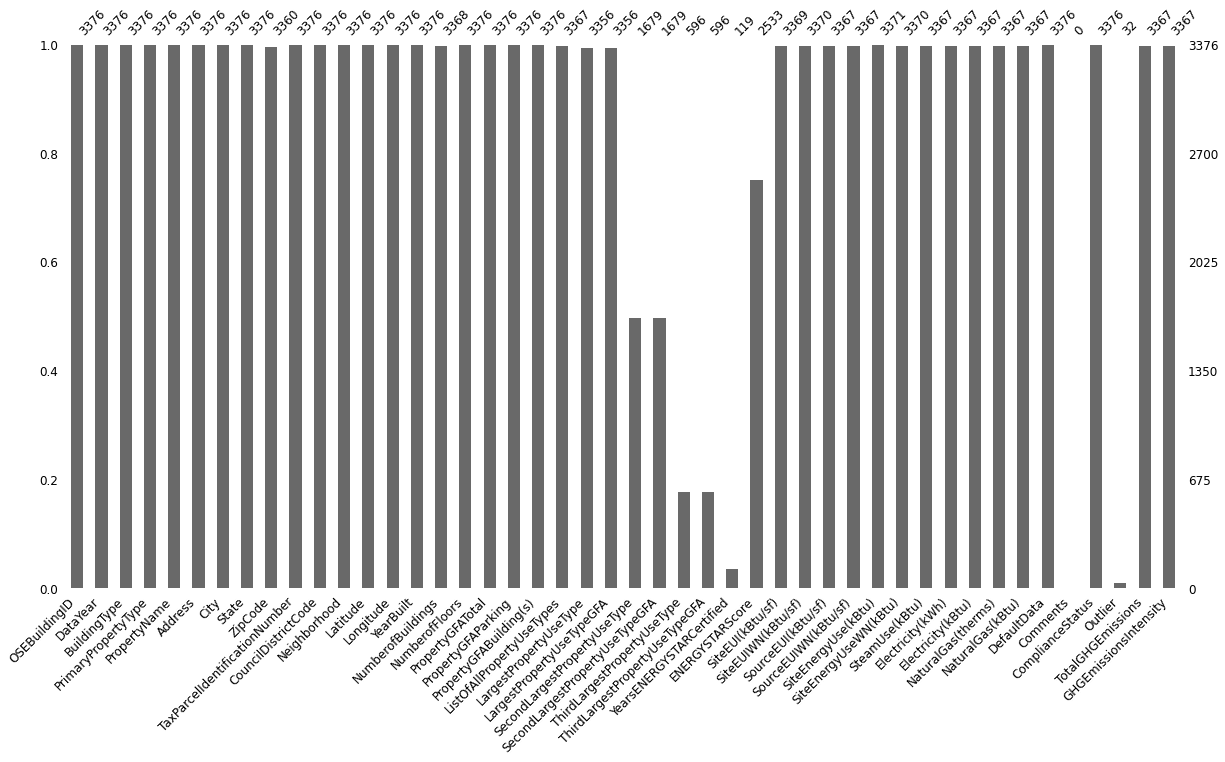

In [9]:
import missingno as msno

msno.bar(Data, figsize=(20,10), fontsize=12, labels=True);
#msno.matrix(Data, figsize=(40,10), fontsize=18, labels=True)

In [10]:
def search(Data, suffix=None):
  WN = []
  for col in Data.columns:
      if suffix in col: 
        WN.append(col)
  return WN

In [11]:
# elimination des variables que ne nous intéressent pas
Data.drop(['State','Comments','ZipCode','City'], axis=1, inplace=True)

In [12]:
# WN (Weather Normalized) qui sont des corrections des conditions climatiques.
#Suppression des variables avec suffixe WN
Data.drop(search(Data,'WN'), axis=1, inplace=True)

In [13]:
#Suppression des variables redondantes
redundant = ['NaturalGas(therms)','Electricity(kWh)']
Data.drop(redundant, axis=1, inplace=True)

In [14]:
Data['ComplianceStatus']

0                          Compliant
1                          Compliant
2                          Compliant
3                          Compliant
4                          Compliant
                    ...             
3371    Error - Correct Default Data
3372                       Compliant
3373                       Compliant
3374                       Compliant
3375                       Compliant
Name: ComplianceStatus, Length: 3376, dtype: object

In [15]:
for i in Data['ComplianceStatus'].unique():
    print(i)

Compliant
Error - Correct Default Data
Missing Data
Non-Compliant


In [16]:
Data[Data['ComplianceStatus'].str.contains('Missing Data')==True].head()

OSEBuildingID  DataYear       BuildingType PrimaryPropertyType  \
28             34      2016  SPS-District K-12         K-12 School   
31             37      2016  SPS-District K-12         K-12 School   
62             87      2016  SPS-District K-12         K-12 School   
81            118      2016  SPS-District K-12         K-12 School   
85            122      2016  SPS-District K-12         K-12 School   

                PropertyName               Address  \
28            Meany Building  301/300 21st Ave. E.   
31       John Hay Elementary      201 Garfield St.   
62  Arbor Heights Elementary   3701 S.W. 104th St.   
81            Pathfinder K-8   1901 SW Genesee St.   
85      John Muir Elementary    3301 S. Horton St.   

   TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
28                    0688000090                    3                Central   
31                    0809000005                    7  MAGNOLIA / QUEEN ANNE   
62                    2518400005                    1              SOUTHWEST   
81                    1324039116                    1               DELRIDGE   
85                    1524049002                    2              SOUTHEAST   

    Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
28  47.62266 -122.30547       1955                1.0               1   
31  47.63290 -122.35172       1989                1.0               2   
62  47.50970 -122.37759       1948                1.0               2   
81  47.56360 -122.35800       1999                1.0               3   
85  47.57324 -122.29058       1991                1.0               2   

    PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
28            126351                   0                  126351   
31             51582                   0                   51582   
62             53352                   0                   53352   
81             74468                   0                   74468   
85             58933                   0                   58933   

   ListOfAllPropertyUseTypes LargestPropertyUseType  \
28               K-12 School            K-12 School   
31               K-12 School            K-12 School   
62               K-12 School            K-12 School   
81               K-12 School            K-12 School   
85               K-12 School            K-12 School   

    LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
28                   126351.0                          NaN   
31                    55166.0                          NaN   
62                    65568.0                          NaN   
81                    75364.0                          NaN   
85                    60725.0                          NaN   

    SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
28                              NaN                         NaN   
31                              NaN                         NaN   
62                              NaN                         NaN   
81                              NaN                         NaN   
85                              NaN                         NaN   

    ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
28                             NaN                      NaN              NaN   
31                             NaN                      NaN              NaN   
62                             NaN                      NaN              NaN   
81                             NaN                      NaN              NaN   
85                             NaN                      NaN              NaN   

    SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
28               0.0                 0.0                  0.0             0.0   
31               0.0                 0.0                  0.0             0.0   
62               0.0                 0.0                  0.0             0.0   
81               

In [17]:
# Supression de cette variable car il y a Error - Correct Default Data que nous ne savons pas a quaoi correspond 
Data.drop(['ComplianceStatus'], axis=1, inplace=True)

In [18]:
Data.min()

OSEBuildingID                                                1
DataYear                                                  2016
BuildingType                                            Campus
PrimaryPropertyType                        Distribution Center
PropertyName                                  #4706 Bitterlake
Address                            (ID23682) 3204 SW MORGAN ST
TaxParcelIdentificationNumber                       0000000000
CouncilDistrictCode                                          1
Neighborhood                                           BALLARD
Latitude                                              47.49917
Longitude                                           -122.41425
YearBuilt                                                 1900
NumberofBuildings                                          0.0
NumberofFloors                                               0
PropertyGFATotal                                         11285
PropertyGFAParking                                     

In [19]:
# Correction du nombre de bâtiments et d'étages (ne peut être nul ou NaN)

In [20]:
Data.isna().sum() / len(Data)*100

OSEBuildingID                       0.000000
DataYear                            0.000000
BuildingType                        0.000000
PrimaryPropertyType                 0.000000
PropertyName                        0.000000
Address                             0.000000
TaxParcelIdentificationNumber       0.000000
CouncilDistrictCode                 0.000000
Neighborhood                        0.000000
Latitude                            0.000000
Longitude                           0.000000
YearBuilt                           0.000000
NumberofBuildings                   0.236967
NumberofFloors                      0.000000
PropertyGFATotal                    0.000000
PropertyGFAParking                  0.000000
PropertyGFABuilding(s)              0.000000
ListOfAllPropertyUseTypes           0.266588
LargestPropertyUseType              0.592417
LargestPropertyUseTypeGFA           0.592417
SecondLargestPropertyUseType       50.266588
SecondLargestPropertyUseTypeGFA    50.266588
ThirdLarge

In [21]:
Data['NumberofBuildings'].fillna(0, inplace=True)
Data['NumberofBuildings'].replace(0, 1, inplace=True)
Data['NumberofFloors'].fillna(0, inplace=True)
Data['NumberofFloors'].replace(0, 1, inplace=True)

In [22]:
Data['NumberofBuildings'].unique()

array([  1.,   3.,   2.,   4.,  27.,   6.,  11.,  14.,   9.,   5.,   7.,
         8.,  16.,  23.,  10., 111.])

In [23]:
Data['NumberofFloors'].unique()

array([12, 11, 41, 10, 18,  2,  8, 15,  6, 25,  9, 33, 28,  5, 19,  7,  1,
        3,  4, 24, 20, 34, 16, 23, 17, 36, 22, 47, 29, 14, 49, 37, 42, 63,
       13, 21, 55, 46, 30, 56, 26, 76, 27, 31, 99, 38, 39, 32, 40])

In [24]:
# Localisation

In [25]:
import folium
map_osm = folium.Map()
map_osm = folium.Map(location=[Data['Latitude'].mean(), Data['Longitude'].mean()],zoom_start=11)
for i in range(0,len(Data)):
    folium.Circle([Data.iloc[i]['Latitude'],Data.iloc[i]['Longitude']], 
                      popup=Data.iloc[i]['Address'], radius =100).add_to(map_osm)
map_osm

In [26]:
Data.isna().sum().sort_values(ascending=False)

Outlier                            3344
YearsENERGYSTARCertified           3257
ThirdLargestPropertyUseTypeGFA     2780
ThirdLargestPropertyUseType        2780
SecondLargestPropertyUseTypeGFA    1697
SecondLargestPropertyUseType       1697
ENERGYSTARScore                     843
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
ListOfAllPropertyUseTypes             9
TotalGHGEmissions                     9
NaturalGas(kBtu)                      9
Electricity(kBtu)                     9
SteamUse(kBtu)                        9
SourceEUI(kBtu/sf)                    9
GHGEmissionsIntensity                 9
SiteEUI(kBtu/sf)                      7
SiteEnergyUse(kBtu)                   5
PropertyGFAParking                    0
BuildingType                          0
PrimaryPropertyType                   0
DefaultData                           0
PropertyName                          0
Address                               0
TaxParcelIdentificationNumber         0


In [27]:
# Je vais eliminer le parametre 'Outlier' car ca ne contiens pas trop des valeurs      
Data.drop(['Outlier'],axis=1)
Data.shape

(3376, 36)

<AxesSubplot:title={'center':'NaN par colonne'}, ylabel='Count'>

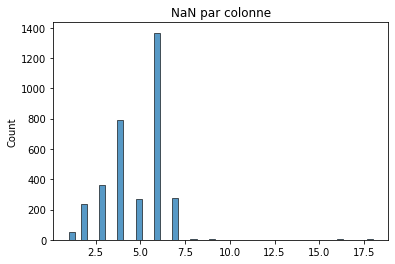

In [28]:
plt.title('NaN par colonne')
sns.histplot(Data.isna().sum(axis=1), bins=50)

# Elimination des NaNs

In [29]:
Data.dropna(how = 'all', axis=0, inplace=True)
Data.shape

(3376, 36)

Complétion des NaN de certaines variables par des valeurs Complétion avec 0 :

In [30]:
col_nan_to_zero = ['ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                   'LargestPropertyUseTypeGFA','SteamUse(kBtu)',
                   'Electricity(kBtu)','NaturalGas(kBtu)']
Data[col_nan_to_zero] = Data[col_nan_to_zero].fillna(0, )

In [31]:
col_no_use = ['LargestPropertyUseType', 'SecondLargestPropertyUseType',
              'ThirdLargestPropertyUseType']
Data[col_no_use] = Data[col_no_use].fillna('No information')

In [32]:
Data[Data['LargestPropertyUseType'] == 'No information']

OSEBuildingID  DataYear          BuildingType  \
353             496      2016        NonResidential   
578             773      2016        NonResidential   
758           19798      2016  Multifamily LR (1-4)   
1077          20762      2016  Multifamily HR (10+)   
1147          21103      2016        NonResidential   
1483          21950      2016  Multifamily MR (5-9)   
1756          23319      2016  Multifamily HR (10+)   
1768          23355      2016  Multifamily LR (1-4)   
1792          23437      2016  Multifamily LR (1-4)   
2321          25431      2016  Multifamily LR (1-4)   
2336          25302      2016  Multifamily LR (1-4)   
2414          25568      2016        NonResidential   
2459          25711      2016        NonResidential   
2474          25752      2016  Multifamily LR (1-4)   
2480          25763      2016  Multifamily LR (1-4)   
2545          26026      2016  Multifamily LR (1-4)   
2670          26532      2016        NonResidential   
2886          27343      2016  Multifamily LR (1-4)   
3040          27966      2016  Multifamily LR (1-4)   
3348          50082      2016  Multifamily LR (1-4)   

              PrimaryPropertyType                      PropertyName  \
353         Self-Storage Facility                  Market St Center   
578   Small- and Mid-Sized Office                  SEATTLE BUILDING   
758          Low-Rise Multifamily                    SANDHURST APTS   
1077        High-Rise Multifamily                       The Concord   
1147                        Hotel                   Palladian Hotel   
1483         Mid-Rise Multifamily     500 ELLIOTT HOMES CONDOMINIUM   
1756        High-Rise Multifamily                    Kelleher House   
1768         Low-Rise Multifamily                       GRAHAM VIEW   
1792         Low-Rise Multifamily                  MERCER CREST APT   
2321         Low-Rise Multifamily                     PONDERAY APTS   
2336         Low-Rise Multifamily                      Maria Chalet   
2414  Small- and Mid-Sized Office               Talon Northlake LLC   
2459                   Restaurant  BUSH GARDEN - RESTURANT & LOUNGE   
2474         Low-Rise Multifamily               GRANVIEW APARTMENTS   
2480         Low-Rise Multifamily                      Villa Andora   
2545         Low-Rise Multifamily       Westwood Plaza Condominiums   
2670           Mixed Use Property                  KALBERG BUILDING   
2886         Low-Rise Multifamily                     Ravenna Woods   
3040         Low-Rise Multifamily                    Pinehurst Lane   
3348         Low-Rise Multifamily                    STREAM FIFTEEN   

                     Address TaxParcelIdentificationNumber  \
353    2811 NW Market Street                    1175001235   
578          215 COLUMBIA ST                    0939000245   
758   7239 SAND POINT WAY NE                    0225049032   
1077       2929 First Avenue                    1734800000   
1147      2000 Second Avenue                    1977201140   
1483       500 ELLIOTT AVE W                    2569800000   
1756          1120 Spring St                    3801000000   
1768  6040 CALIFORNIA AVE SW                    7625703280   
1792         500 W MERCER ST                    3876900230   
2321        5625 15TH AVE NE                    5226300030   
2336    9710 Greenwood Ave N                    5145600000   
2414    1341 N Northlake Way                    4088804565   
2459     614 S MAYNARD AVE S                    5247802410   
2474          1120 N 93RD ST                    9267200155   
2480  1520 CALIFORNIA AVE SW                    9272201340   
2545      2421 SW Trenton St                    9325000000   
2670  4515 UNIVERSITY WAY NE                    8816401120   
2886         2300 NE 89TH ST                    7181200000   
3040       11532 15th Ave NE                    6798800000   
3348          605 15TH AVE E                    3303700030   

      CouncilDistrictCode           Neighborhood  Latit

Le but de notre programme étant de supprimer les relevés coûteux pour les années à venir, nous allons donc exclure toutes les données de relève de notre dataset.

In [33]:
Data = Data.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'], axis=1)

In [34]:
Data.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0
ThirdLargestPropertyUseType           0
ThirdLargestPropertyUseTypeGFA        0
YearsENERGYSTARCertified           3257


Il reste des entrées pour lesquelles nous n'avons pas d'information de consommation d'énergie

In [35]:
Data[Data['TotalGHGEmissions'].isna()]

OSEBuildingID  DataYear          BuildingType  \
578             773      2016        NonResidential   
758           19798      2016  Multifamily LR (1-4)   
1768          23355      2016  Multifamily LR (1-4)   
1792          23437      2016  Multifamily LR (1-4)   
2321          25431      2016  Multifamily LR (1-4)   
2474          25752      2016  Multifamily LR (1-4)   
2480          25763      2016  Multifamily LR (1-4)   
2670          26532      2016        NonResidential   
3348          50082      2016  Multifamily LR (1-4)   

              PrimaryPropertyType         PropertyName  \
578   Small- and Mid-Sized Office     SEATTLE BUILDING   
758          Low-Rise Multifamily       SANDHURST APTS   
1768         Low-Rise Multifamily          GRAHAM VIEW   
1792         Low-Rise Multifamily     MERCER CREST APT   
2321         Low-Rise Multifamily        PONDERAY APTS   
2474         Low-Rise Multifamily  GRANVIEW APARTMENTS   
2480         Low-Rise Multifamily         Villa Andora   
2670           Mixed Use Property     KALBERG BUILDING   
3348         Low-Rise Multifamily       STREAM FIFTEEN   

                     Address TaxParcelIdentificationNumber  \
578          215 COLUMBIA ST                    0939000245   
758   7239 SAND POINT WAY NE                    0225049032   
1768  6040 CALIFORNIA AVE SW                    7625703280   
1792         500 W MERCER ST                    3876900230   
2321        5625 15TH AVE NE                    5226300030   
2474          1120 N 93RD ST                    9267200155   
2480  1520 CALIFORNIA AVE SW                    9272201340   
2670  4515 UNIVERSITY WAY NE                    8816401120   
3348          605 15TH AVE E                    3303700030   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
578                     7               DOWNTOWN  47.60380 -122.33293   
758                     4              NORTHEAST  47.68149 -122.26471   
1768                    1              SOUTHWEST  47.54731 -122.38656   
1792                    7  MAGNOLIA / QUEEN ANNE  47.62479 -122.36364   
2321                    4              NORTHEAST  47.67025 -122.31232   
2474                    6              NORTHWEST  47.69658 -122.34342   
2480                    1              SOUTHWEST  47.58968 -122.38587   
2670                    4              NORTHEAST  47.66182 -122.31345   
3348                    3                   EAST  47.62441 -122.31300   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
578        1924                1.0               4             63150   
758        1977                1.0               3             33166   
1768       1992                1.0               4             29357   
1792       1957                1.0               4             23636   
2321       1963                1.0               4             28472   
2474       1989                1.0               4             29562   
2480       1969                1.0               3             30420   
2670       1928                1.0               2             20760   
3348       2015                1.0               4             36685   

      PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
578                    0                   63150                       NaN   
758                    0                   33166                       NaN   
1768                   0                   29357                       NaN   
1792                   0                   23636                       NaN   
2321                   0                   28472                       NaN   
2474                8531                   21031                       NaN   
2480                   0                   30420                       NaN   
2670                   0                   20760                       NaN   
3348                8254                   28431                       NaN   

     LargestProperty

In [36]:
indexnan = Data['TotalGHGEmissions'].index[Data['TotalGHGEmissions'].isnull()]

Data = Data.drop(index=indexnan)

In [37]:
Data[Data.TotalGHGEmissions==0]

OSEBuildingID  DataYear          BuildingType  \
28               34      2016     SPS-District K-12   
152             242      2016     SPS-District K-12   
304             435      2016        NonResidential   
513             700      2016        NonResidential   
746           19776      2016        NonResidential   
760           19801      2016  Multifamily LR (1-4)   
1323          21524      2016  Multifamily LR (1-4)   
1361          21616      2016     SPS-District K-12   
1549          22363      2016  Multifamily LR (1-4)   

              PrimaryPropertyType                        PropertyName  \
28                    K-12 School                      Meany Building   
152                   K-12 School             Olympic View Elementary   
304                         Other  Washington State Convention Center   
513   Supermarket / Grocery Store           IUC- Whole Foods Interbay   
746                         Other      Welcome Home Society - PriceCo   
760                         Other                  APEX BELLTOWN COOP   
1323         Low-Rise Multifamily              Minor Tower Apartments   
1361                  K-12 School            Olympic Hills Elementary   
1549         Low-Rise Multifamily                   Forte Condominium   

                    Address TaxParcelIdentificationNumber  \
28     301/300 21st Ave. E.                    0688000090   
152       504 N.E. 95th St.                    5100404840   
304             705 Pike St                    1978200105   
513   2001 15th Avenue West                    7666201460   
746      13537 Aurora Ave N                    0164000020   
760          2225 First Ave                    0246300000   
1323       2525 Minor Ave E                    2025049091   
1361   13018 20th Ave. N.E.                    2126049041   
1549        840 NE 125th St                    2607980000   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
28                      3                Central  47.62266 -122.30547   
152                     5                  NORTH  47.69823 -122.32126   
304                     7               DOWNTOWN  47.61195 -122.33167   
513                     7  MAGNOLIA / QUEEN ANNE  47.63718 -122.37734   
746                     5              NORTHWEST  47.72777 -122.34503   
760                     7               DOWNTOWN  47.61294 -122.34638   
1323                    4             LAKE UNION  47.64272 -122.32866   
1361                    5                  NORTH  47.72369 -122.30676   
1549                    5                  North  47.71965 -122.31877   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
28         1955                1.0               1            126351   
152        1989                1.0               2             52792   
304        1990                1.0               6           1400000   
513        2008                1.0               1             57176   
746        2002                1.0               1             29924   
760        1909                1.0               3             30700   
1323       1974                1.0               4             37361   
1361       1954                1.0               1             42292   
1549       1988                1.0               4             47647   

      PropertyGFAParking  PropertyGFABuilding(s)  \
28                     0                  126351   
152                    0                   52792   
304                    0                 1400000   
513                    0                   57176   
746                    0                   29924   
760                    0                   30700   
1323                4735                   32626   
1361                   0                   42292   
1549                   0                   47647   

                              ListOfAllPropertyUseTypes  \
28                                          K-12 School   
152                   

In [38]:
index_zero = Data['TotalGHGEmissions'].index[Data['TotalGHGEmissions']==0]

Data = Data.drop(index=index_zero)

In [39]:
Data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'DefaultData', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

# 4. Analyse exploratoire & Feature Engineering

In [40]:
columns_to_drop = ['PropertyName', #similaire à ID
                   'TaxParcelIdentificationNumber', #similaire à ID
                   #'ListOfAllPropertyUseTypes', #donnée figurant dans d'autres colonnes
                   'DefaultData', #je ne comprend pas la utilite
                   'Address', #non conservé (latitude et longitude préférées)
                   'Outlier', #trop de données manquantes
                   'YearsENERGYSTARCertified' #données incomplètes
                  ]

En ce qui concerne l'énergie, nous pouvons éliminer également les données de surface.

In [41]:
columns_to_drop += ['SiteEUI(kBtu/sf)',
                    'SourceEUI(kBtu/sf)']

In [42]:
for column in columns_to_drop:
    try:
        Data.drop(column, axis=1, inplace=True)
    except:
        print('colonne {} absente du jeu de donnée'.format(column))

In [43]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3358 entries, 0 to 3375
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3358 non-null   int64  
 1   DataYear                         3358 non-null   int64  
 2   BuildingType                     3358 non-null   object 
 3   PrimaryPropertyType              3358 non-null   object 
 4   CouncilDistrictCode              3358 non-null   int64  
 5   Neighborhood                     3358 non-null   object 
 6   Latitude                         3358 non-null   float64
 7   Longitude                        3358 non-null   float64
 8   YearBuilt                        3358 non-null   int64  
 9   NumberofBuildings                3358 non-null   float64
 10  NumberofFloors                   3358 non-null   int64  
 11  PropertyGFATotal                 3358 non-null   int64  
 12  PropertyGFAParking  

In [44]:
df = Data[['OSEBuildingID', 'DataYear', 'PropertyGFATotal', 'YearBuilt', 'NumberofFloors', 'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'PropertyGFAParking', 'PropertyGFABuilding(s)']]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3358 entries, 0 to 3375
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3358 non-null   int64  
 1   DataYear                3358 non-null   int64  
 2   PropertyGFATotal        3358 non-null   int64  
 3   YearBuilt               3358 non-null   int64  
 4   NumberofFloors          3358 non-null   int64  
 5   PrimaryPropertyType     3358 non-null   object 
 6   BuildingType            3358 non-null   object 
 7   Neighborhood            3358 non-null   object 
 8   TotalGHGEmissions       3358 non-null   float64
 9   SiteEnergyUse(kBtu)     3358 non-null   float64
 10  PropertyGFAParking      3358 non-null   int64  
 11  PropertyGFABuilding(s)  3358 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 341.0+ KB


In [46]:
for i in df.BuildingType.unique():
    print (i)

NonResidential
Nonresidential COS
Multifamily MR (5-9)
SPS-District K-12
Campus
Multifamily LR (1-4)
Multifamily HR (10+)
Nonresidential WA


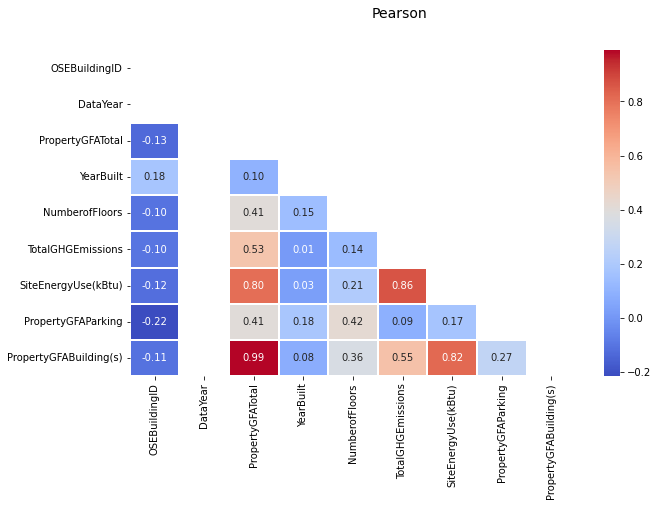

In [47]:
# Correlation Matrix Heatmap 
# DataFrame.corr(method='pearson', min_periods=1)

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(corr, annot=True, mask=mask, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
# f.subplots_adjust(top=0.93)
t= f.suptitle('Pearson', fontsize=14)

In [48]:
# # Correlation Matrix Heatmap 
# # DataFrame.corr(method='pearson', min_periods=1)

# corr = df.corr()
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(10,6))
# hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
#                  linewidths=.05)
# f.subplots_adjust(top=0.93)
# t= f.suptitle('Pearson', fontsize=14)

In [49]:
# bâtiments référencés 'NonResidential'

df = df[((df['BuildingType'].str.contains('Nonresidential COS')==True) | (df['BuildingType'].str.contains('NonResidential')==True) | (df['BuildingType'].str.contains('Nonresidential WA')==True) | (df['BuildingType'].str.contains('SPS-District K-12 ')==True) | (df['BuildingType'].str.contains('Campus')==True))]
df

OSEBuildingID  DataYear  PropertyGFATotal  YearBuilt  NumberofFloors  \
0                 1      2016             88434       1927              12   
1                 2      2016            103566       1996              11   
2                 3      2016            956110       1969              41   
3                 5      2016             61320       1926              10   
4                 8      2016            175580       1980              18   
...             ...       ...               ...        ...             ...   
3371          50222      2016             12294       1990               1   
3372          50223      2016             16000       2004               1   
3373          50224      2016             13157       1974               1   
3374          50225      2016             14101       1989               1   
3375          50226      2016             18258       1938               1   

     PrimaryPropertyType        BuildingType           Neighborhood  \
0                  Hotel      NonResidential               DOWNTOWN   
1                  Hotel      NonResidential               DOWNTOWN   
2                  Hotel      NonResidential               DOWNTOWN   
3                  Hotel      NonResidential               DOWNTOWN   
4                  Hotel      NonResidential               DOWNTOWN   
...                  ...                 ...                    ...   
3371              Office  Nonresidential COS       GREATER DUWAMISH   
3372               Other  Nonresidential COS               DOWNTOWN   
3373               Other  Nonresidential COS  MAGNOLIA / QUEEN ANNE   
3374  Mixed Use Property  Nonresidential COS       GREATER DUWAMISH   
3375  Mixed Use Property  Nonresidential COS       GREATER DUWAMISH   

      TotalGHGEmissions  SiteEnergyUse(kBtu)  PropertyGFAParking  \
0                249.98         7.226362e+06                   0   
1                295.86         8.387933e+06               15064   
2               2089.28         7.258702e+07              196718   
3                286.43         6.794584e+06                   0   
4                505.01         1.417261e+07               62000   
...                 ...                  ...                 ...   
3371              20.94         8.497457e+05                   0   
3372              32.17         9.502762e+05                   0   
3373             223.54         5.765898e+06                   0   
3374              22.11         7.194712e+05                   0   
3375              41.27         1.152896e+06                   0   

      PropertyGFABuilding(s)  
0                      88434  
1                      88502  
2                     759392  
3                      61320  
4                     113580  
...                      ...  
3371                   12294  
3372                   16000  
3373                   13157  
3374                   14101  
3375                   18258  

[1565 rows x 12 columns]

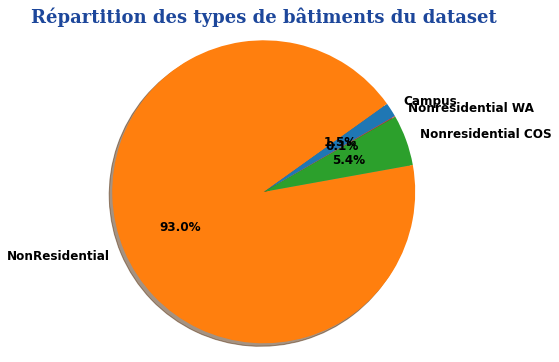

In [50]:
building_type = df.groupby(by='BuildingType')['OSEBuildingID'].nunique()
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du dataset", fontdict=font_title)
plt.show()

In [51]:
# type des batiments non residentiels 
df.loc[(df['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    287
Other                          183
Warehouse                      180
Large Office                   168
Mixed Use Property             101
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             51
Supermarket / Grocery Store     39
K-12 School                     39
Medical Office                  38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

In [52]:
df['BuildingType'].value_counts()

NonResidential        1455
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [53]:
#  1 seule valeur dans 'Nonresidential WA', pas importante pour la analyse
index_to_drop=df[df['BuildingType']=="Nonresidential WA"].index
df.drop(index_to_drop, inplace=True)

# Années de construction

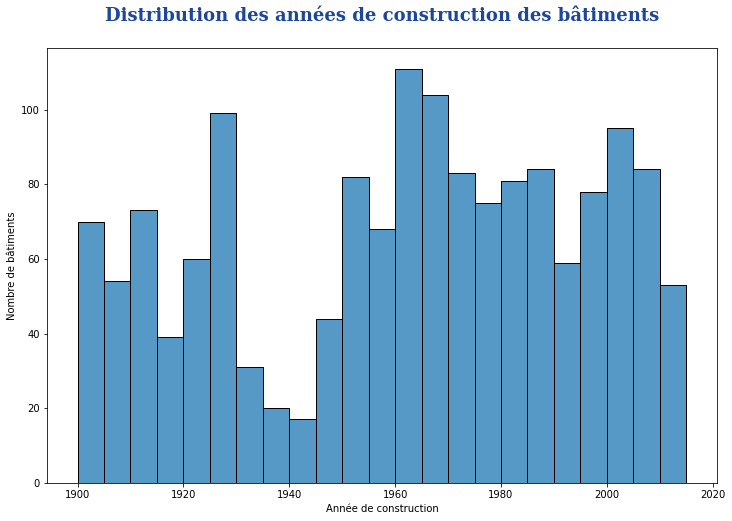

In [54]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=df, x='YearBuilt', bins=int((df.YearBuilt.max() - df.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", fontdict=font_title)
plt.show()

Construction de une nouvelle variable Years pour reduire la dispression des donnes et suppression de la variable année de construction 

In [55]:
# column ['DataYear', 'YearBuilt'] redundansts car j'ai cree une nouvelle colunne DataYear

df.insert (0, "Years", df['DataYear'] - df['YearBuilt'])


df = df.drop(['DataYear', 'YearBuilt'], axis=1)


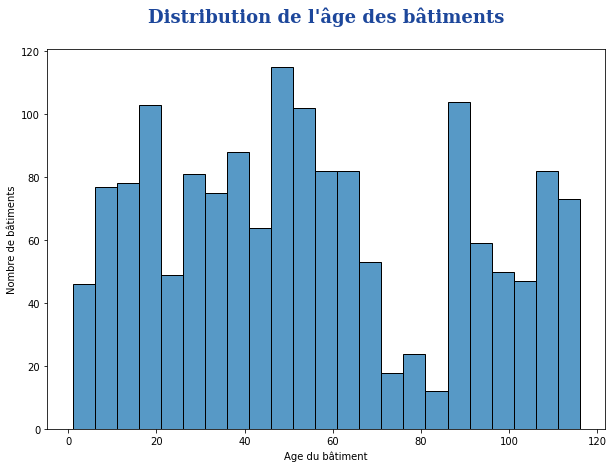

In [56]:
fig = plt.figure(figsize=(10,7))
ax = sns.histplot(data=df, x='Years', bins=int((df.Years.max() - df.Years.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n", fontdict=font_title)
plt.show()

In [57]:
# Une petite analyse de quelques variables 

In [58]:
var = ['SiteEnergyUse(kBtu)', 'Years', 'PropertyGFATotal', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'TotalGHGEmissions']

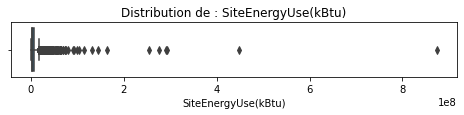

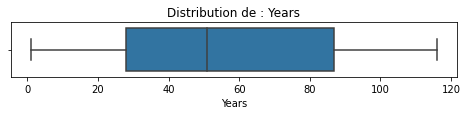

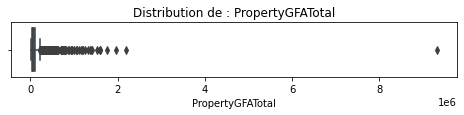

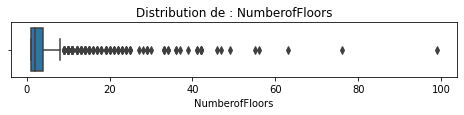

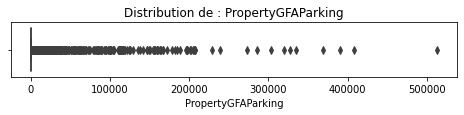

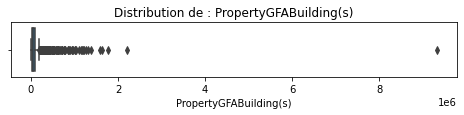

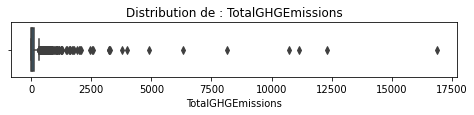

In [59]:
for column in var:
    plt.figure(figsize = (8,1))
    
    sns.boxplot(x=df[column])
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()
sns.set(font_scale=1)

Ont vois des outliers dans nous variables, ca risque d'influencier notre analyse. Ont va les eliminer. 

In [60]:
# Understanding the Pandas .quantile() method to calculate percentiles

df.quantile(
    q=0.95,                      # The percentile to calculate
    axis=0,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
)

Years                     1.100000e+02
OSEBuildingID             4.969670e+04
PropertyGFATotal          4.153444e+05
NumberofFloors            1.300000e+01
TotalGHGEmissions         6.046335e+02
SiteEnergyUse(kBtu)       3.316101e+07
PropertyGFAParking        9.708215e+04
PropertyGFABuilding(s)    3.629419e+05
Name: 0.95, dtype: float64

In [61]:
df[df['PropertyGFATotal']>4.969670e+04]

Years  OSEBuildingID  PropertyGFATotal  NumberofFloors  \
0        89              1             88434              12   
1        20              2            103566              11   
2        47              3            956110              41   
3        90              5             61320              10   
4        36              8            175580              18   
...     ...            ...               ...             ...   
3329      2          50054            536697              13   
3337      2          50062            126823               4   
3338     61          50068             52085               1   
3340      3          50070             72000               1   
3356      1          50094            345290               6   

     PrimaryPropertyType        BuildingType      Neighborhood  \
0                  Hotel      NonResidential          DOWNTOWN   
1                  Hotel      NonResidential          DOWNTOWN   
2                  Hotel      NonResidential          DOWNTOWN   
3                  Hotel      NonResidential          DOWNTOWN   
4                  Hotel      NonResidential          DOWNTOWN   
...                  ...                 ...               ...   
3329        Large Office  Nonresidential COS        LAKE UNION   
3337               Hotel      NonResidential        LAKE UNION   
3338           Warehouse      NonResidential  GREATER DUWAMISH   
3340               Other      NonResidential         NORTHEAST   
3356  Mixed Use Property      NonResidential        LAKE UNION   

      TotalGHGEmissions  SiteEnergyUse(kBtu)  PropertyGFAParking  \
0                249.98            7226362.5                   0   
1                295.86            8387933.0               15064   
2               2089.28           72587024.0              196718   
3                286.43            6794584.0                   0   
4                505.01           14172606.0               62000   
...                 ...                  ...                 ...   
3329             245.16           13239050.0              197659   
3337             131.02            6042399.5               41539   
3338             157.70            3605855.5                4222   
3340              67.65            2925780.0                   0   
3356            1000.06           39364116.0               85028   

      PropertyGFABuilding(s)  
0                      88434  
1                      88502  
2                     759392  
3                      61320  
4                     113580  
...                      ...  
3329                  339038  
3337                   85284  
3338                   47863  
3340                   72000  
3356                  260262  

[756 rows x 11 columns]

In [62]:
index_to_drop=df[df['PropertyGFATotal']>4.969670e+04].index
df.drop(index_to_drop, inplace=True)

In [63]:
df[df['PropertyGFATotal']>4.969670e+04]

Empty DataFrame
Columns: [Years, OSEBuildingID, PropertyGFATotal, NumberofFloors, PrimaryPropertyType, BuildingType, Neighborhood, TotalGHGEmissions, SiteEnergyUse(kBtu), PropertyGFAParking, PropertyGFABuilding(s)]
Index: []

In [64]:
index_to_drop=df[df['Years']>1.100000e+02].index
df.drop(index_to_drop, inplace=True)

In [65]:
index_to_drop=df[df['OSEBuildingID']>4.969670e+04].index
df.drop(index_to_drop, inplace=True)

In [66]:
index_to_drop=df[df['TotalGHGEmissions']>6.046335e+02].index 
df.drop(index_to_drop, inplace=True)

In [67]:
index_to_drop=df[df['SiteEnergyUse(kBtu)']>3.316101e+07].index
df.drop(index_to_drop, inplace=True)

In [68]:
index_to_drop=df[df['PropertyGFAParking']>9.708215e+04].index
df.drop(index_to_drop, inplace=True)

In [69]:
index_to_drop=df[df['NumberofFloors']>1.300000e+01].index
df.drop(index_to_drop, inplace=True)

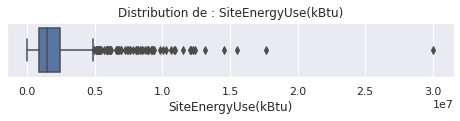

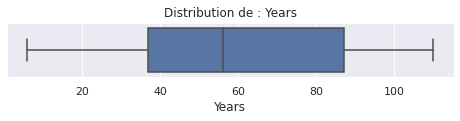

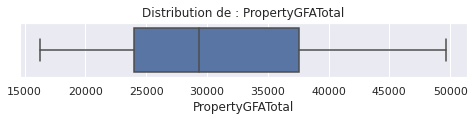

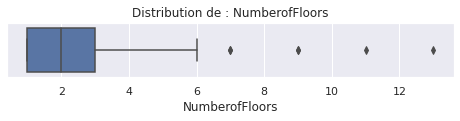

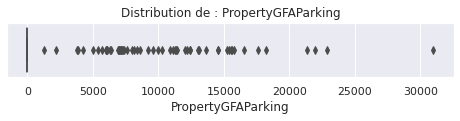

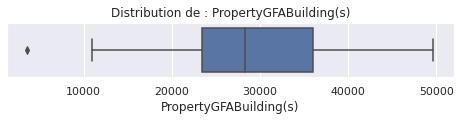

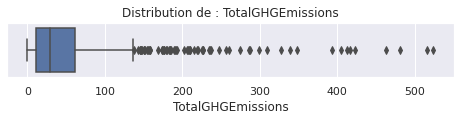

In [70]:
for column in var:
    plt.figure(figsize = (8,1))
    
    sns.boxplot(x=df[column])
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()
sns.set(font_scale=1)

In [71]:
df['PropertyGFATotal'].describe()

count      735.000000
mean     31151.051701
std       8249.933443
min      16300.000000
25%      24000.000000
50%      29340.000000
75%      37550.000000
max      49680.000000
Name: PropertyGFATotal, dtype: float64

In [72]:
# Correction de quelques valeurs dans la variable Neighborhood
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
df['Neighborhood']=df['Neighborhood'].map(lambda x: x.upper())

In [73]:
#Cette fonction permet de visualiser la répartition des émissions de CO2 dans une variable.
def CO2_Neighborhood(variable,df):
    # the_mean=df["GHGEmissions(MetricTonsCO2e)"].mean()
    the_mean=df["TotalGHGEmissions"].mean()
    fig=plt.figure(figsize=[18,7])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.title("C02 emissions distribution by {}".format(variable),size=16)
    sns.boxplot(x=variable, y="TotalGHGEmissions", data=df,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
    plt.hlines(y=the_mean,xmin=-0.5,xmax=len(df[variable].unique())-0.5,color="#6d788b",ls="--",label="Global mean")

    plt.ylabel(" C02 emissions",size=14)
    plt.xticks(range(0,len(df[variable].unique()))
               ,df[variable].unique(),rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

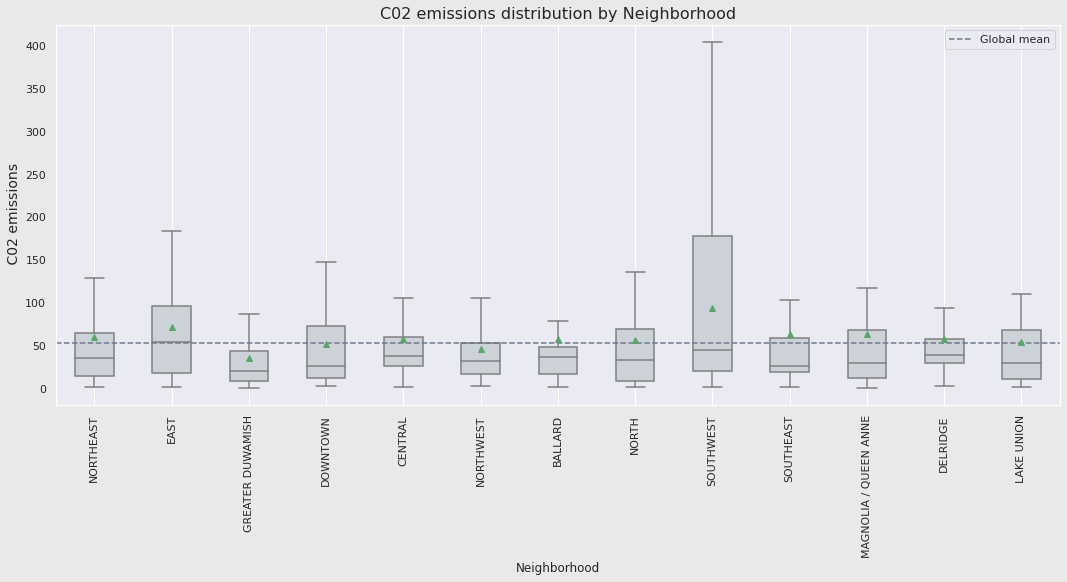

In [74]:
CO2_Neighborhood('Neighborhood',df)

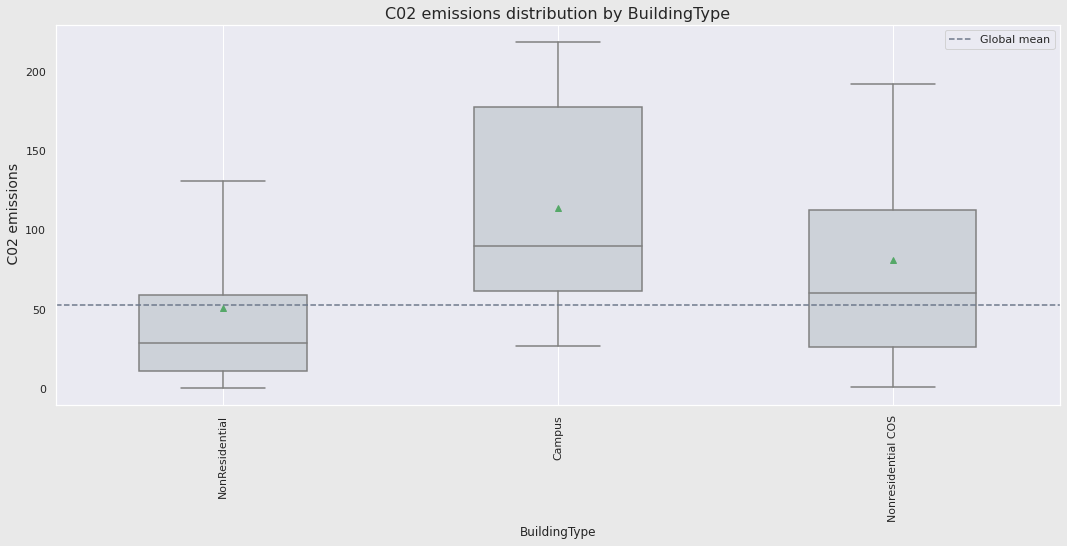

In [75]:
CO2_Neighborhood('BuildingType',df)

# 2. Analyse univariée

In [76]:
numeric_data = df.select_dtypes(include=[np.number])


numeric_data.shape[1]

8

In [77]:
categorical_data = df.select_dtypes(exclude=[np.number])

categorical_data.shape[1]

3

# 2.1 Variables numeriques

In [78]:
from pylab import *
import numpy as np
import matplotlib.pyplot as ptl

# fig, axes = plt.subplots(nrows = 5, ncols = 2)
# Histogram

def Histogram():
    fig, ax = plt.subplots(3,3,figsize=(25,10))
    for idx, (name_feature, df_feature) in enumerate(numeric_data.groupby(level=0,axis=1)):
        df=numeric_data[name_feature]
        ax[idx//3,idx%3].set_title(name_feature, fontsize=14)
        ax[idx//3,idx%3].set_ylabel("Frequency")
        feature_hist=np.histogram(numeric_data[name_feature],bins=15)
        ax[idx//3,idx%3].bar(feature_hist[1][:-1],feature_hist[0],align='edge',width=0.8*(feature_hist[1][1]-feature_hist[1][0]),edgecolor='black', linewidth=1,color='steelblue')
        ax[idx//3,idx%3].text(feature_hist[1][-1],np.max(feature_hist[0])*1.13,r'$\mu$='+str(round(numeric_data[name_feature].mean(),2)), horizontalalignment='right',verticalalignment='top', fontsize=12)
        ax[idx//3,idx%3].set_ylim([0,np.max(feature_hist[0])*1.2])

        fig.tight_layout()

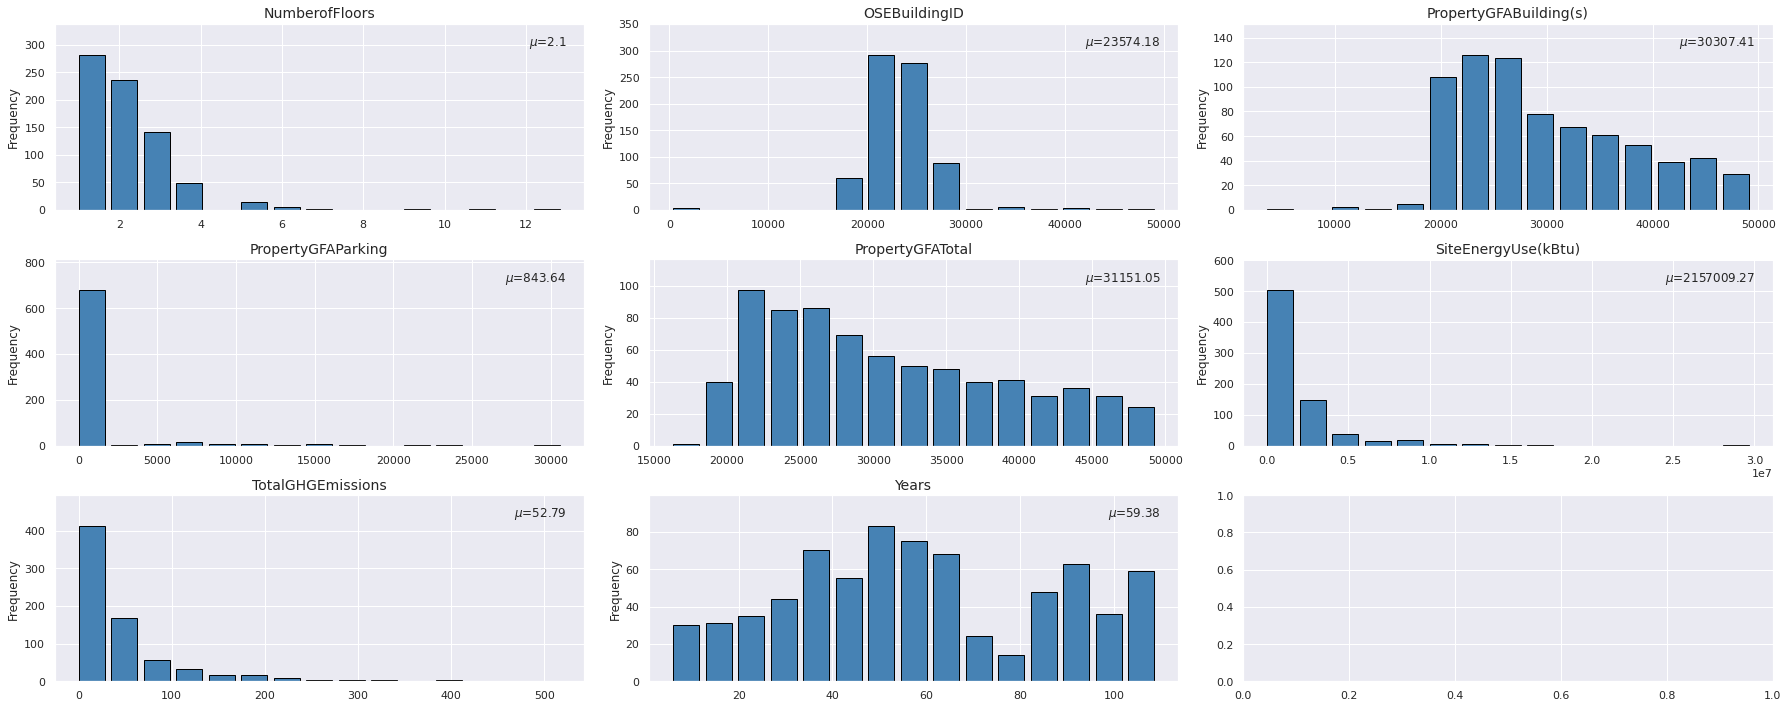

In [79]:
Histogram()

# 2.2 Variables catégoriques 

In [80]:
# Bar Plot
def BarPlot():
    fig, ax = plt.subplots(1,3,figsize = (25,10))
    for idx, (col, impute_cols) in enumerate(categorical_data.groupby(level=0,axis=1)):
        # title = fig.suptitle("Wine Quality Frequency", fontsize=14)

        ax1=ax[idx]
        ax1.set_title(col)
        ax1.set_ylabel("Frequency") 
        w_q = categorical_data[col].value_counts().head(10)
        w_q = (list(w_q.index), list(w_q.values))
        ax1.tick_params(axis='both', which='major', labelsize=8.5)
        ax1.set_xticklabels([i if len(i)<=15 else i[:12] + '...' for i in categorical_data[col].value_counts().head(10).index], rotation = 45, size=14)
        bar = ax1.bar(w_q[0], w_q[1], color='steelblue', 
                edgecolor='black', linewidth=1)
    fig.tight_layout(h_pad=3)
    plt.show()

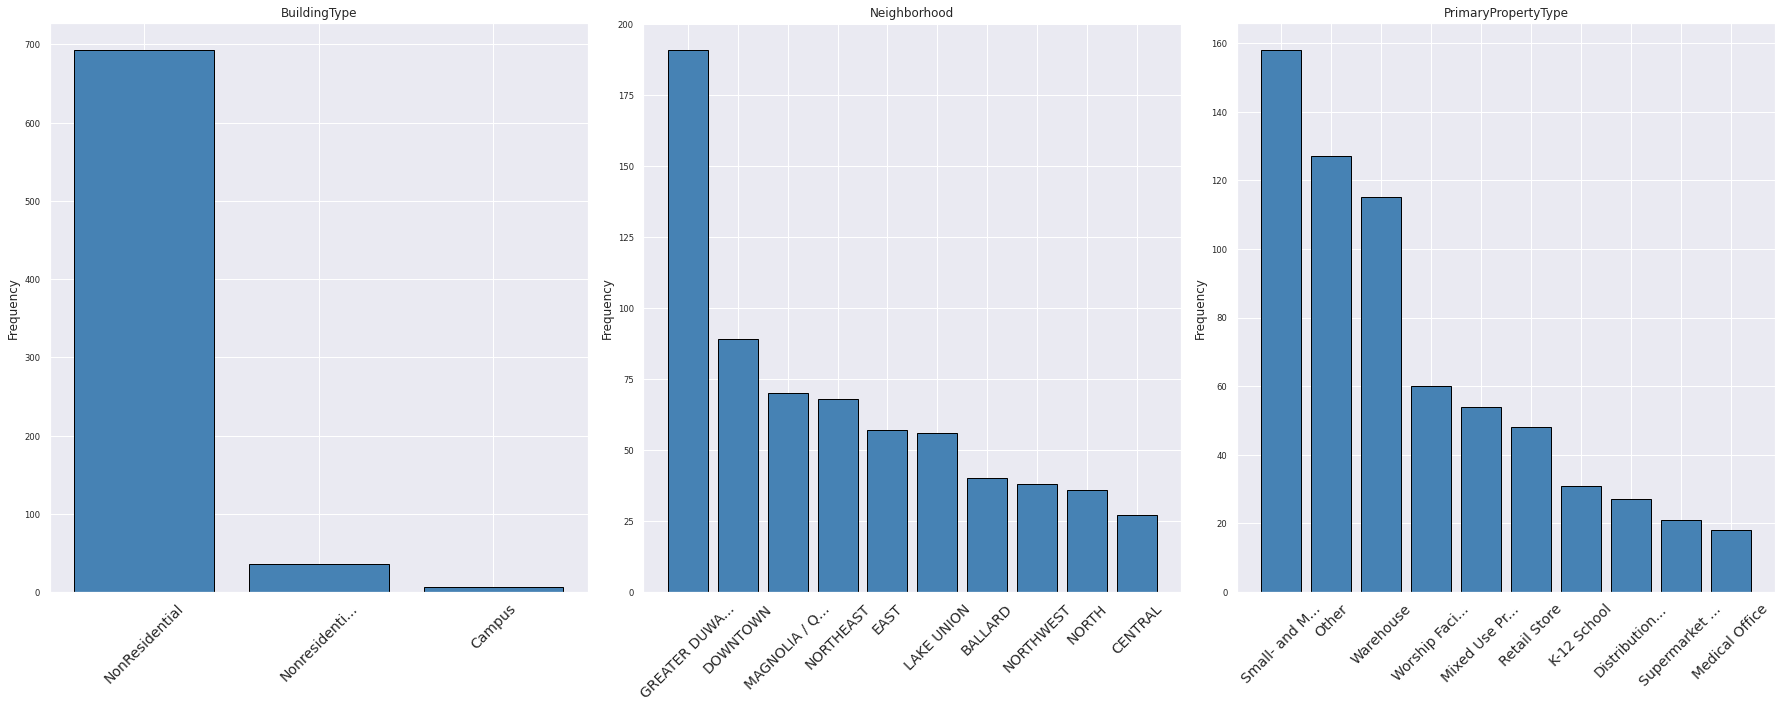

In [81]:
BarPlot()

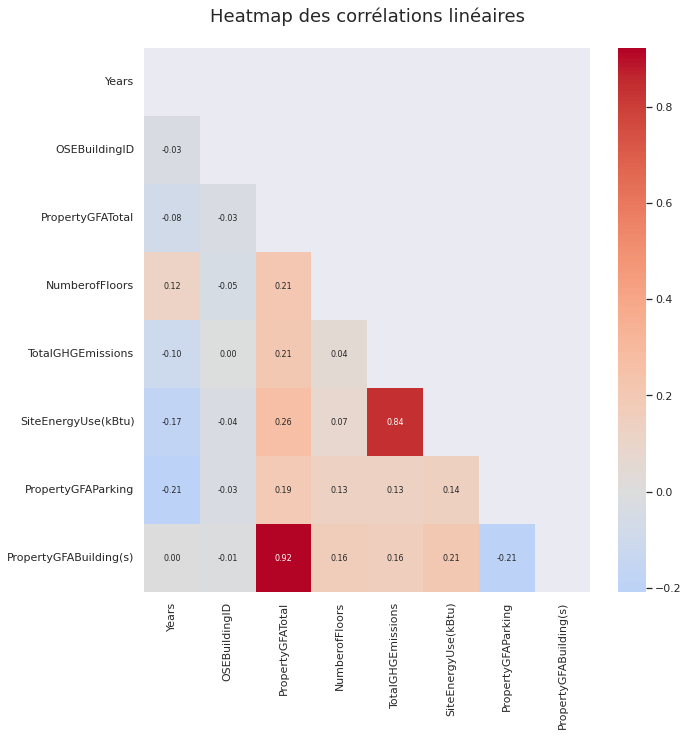

In [82]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize = 18)
plt.show()

In [83]:
df.shape

(735, 11)

# 3. Conversion des valeurs catégorielles en représentation numériques

In [84]:
# categorical_cols = ['PrimaryPropertyType', 'BuildingType', 'Neighborhood']

# from sklearn.preprocessing import LabelEncoder
# One-hot encoding multiple columns
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
# import pandas as pd
# # instantiate labelencoder object
# le = LabelEncoder()

# # apply le on categorical feature columns
# df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))    
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()

# #One-hot-encode the categorical columns.
# #Unfortunately outputs an array instead of dataframe.
# array_hot_encoded = ohe.fit_transform(df[categorical_cols])

# #Convert it to df
# data_hot_encoded = pd.DataFrame(array_hot_encoded, index=df.index)

# #Extract only the columns that didnt need to be encoded
# data_other_cols = df.drop(columns=categorical_cols)

# #Concatenate the two dataframes : 
# data_out = pd.concat([data_hot_encoded, data_other_cols], axis=1)

In [85]:
# df = data_out

In [86]:
df

Years  OSEBuildingID  PropertyGFATotal  NumberofFloors  \
240      47            365             36000               5   
305      28            436             46710               9   
385      50            540             22780               1   
446      70          19746             23000               1   
518      91          19755             20565               3   
...     ...            ...               ...             ...   
3132     56          40034             21931               1   
3144     23          42069             26263               1   
3152    110          43948             39212               2   
3155     48          45287             21400               1   
3160     13          49687             33997               4   

              PrimaryPropertyType        BuildingType           Neighborhood  \
240                         Other      NonResidential              NORTHEAST   
305                         Other      NonResidential                   EAST   
385                     Warehouse      NonResidential       GREATER DUWAMISH   
446                         Other      NonResidential               DOWNTOWN   
518   Small- and Mid-Sized Office      NonResidential               DOWNTOWN   
...                           ...                 ...                    ...   
3132  Small- and Mid-Sized Office      NonResidential              NORTHEAST   
3144  Small- and Mid-Sized Office      NonResidential             LAKE UNION   
3152                        Other  Nonresidential COS       GREATER DUWAMISH   
3155                        Other  Nonresidential COS                CENTRAL   
3160  Supermarket / Grocery Store      NonResidential  MAGNOLIA / QUEEN ANNE   

      TotalGHGEmissions  SiteEnergyUse(kBtu)  PropertyGFAParking  \
240              209.41         3.003849e+07                   0   
305              130.69         4.169432e+06                   0   
385                2.80         4.020513e+05                   0   
446               25.74         7.111184e+05                   0   
518                5.59         8.023125e+05                   0   
...                 ...                  ...                 ...   
3132             145.11         3.947209e+06                   0   
3144              11.40         1.634669e+06                   0   
3152               0.50         7.237040e+04                   0   
3155             158.60         5.170810e+06                   0   
3160              94.63         8.926736e+06                   0   

      PropertyGFABuilding(s)  
240                    36000  
305                    46710  
385                    22780  
446                    23000  
518                    20565  
...                      ...  
3132                   21931  
3144                   26263  
3152                   39212  
3155                   21400  
3160                   33997  

[735 rows x 11 columns]

In [87]:
df = pd.get_dummies(df, columns=['PrimaryPropertyType', 'BuildingType', 'Neighborhood'], drop_first=True)

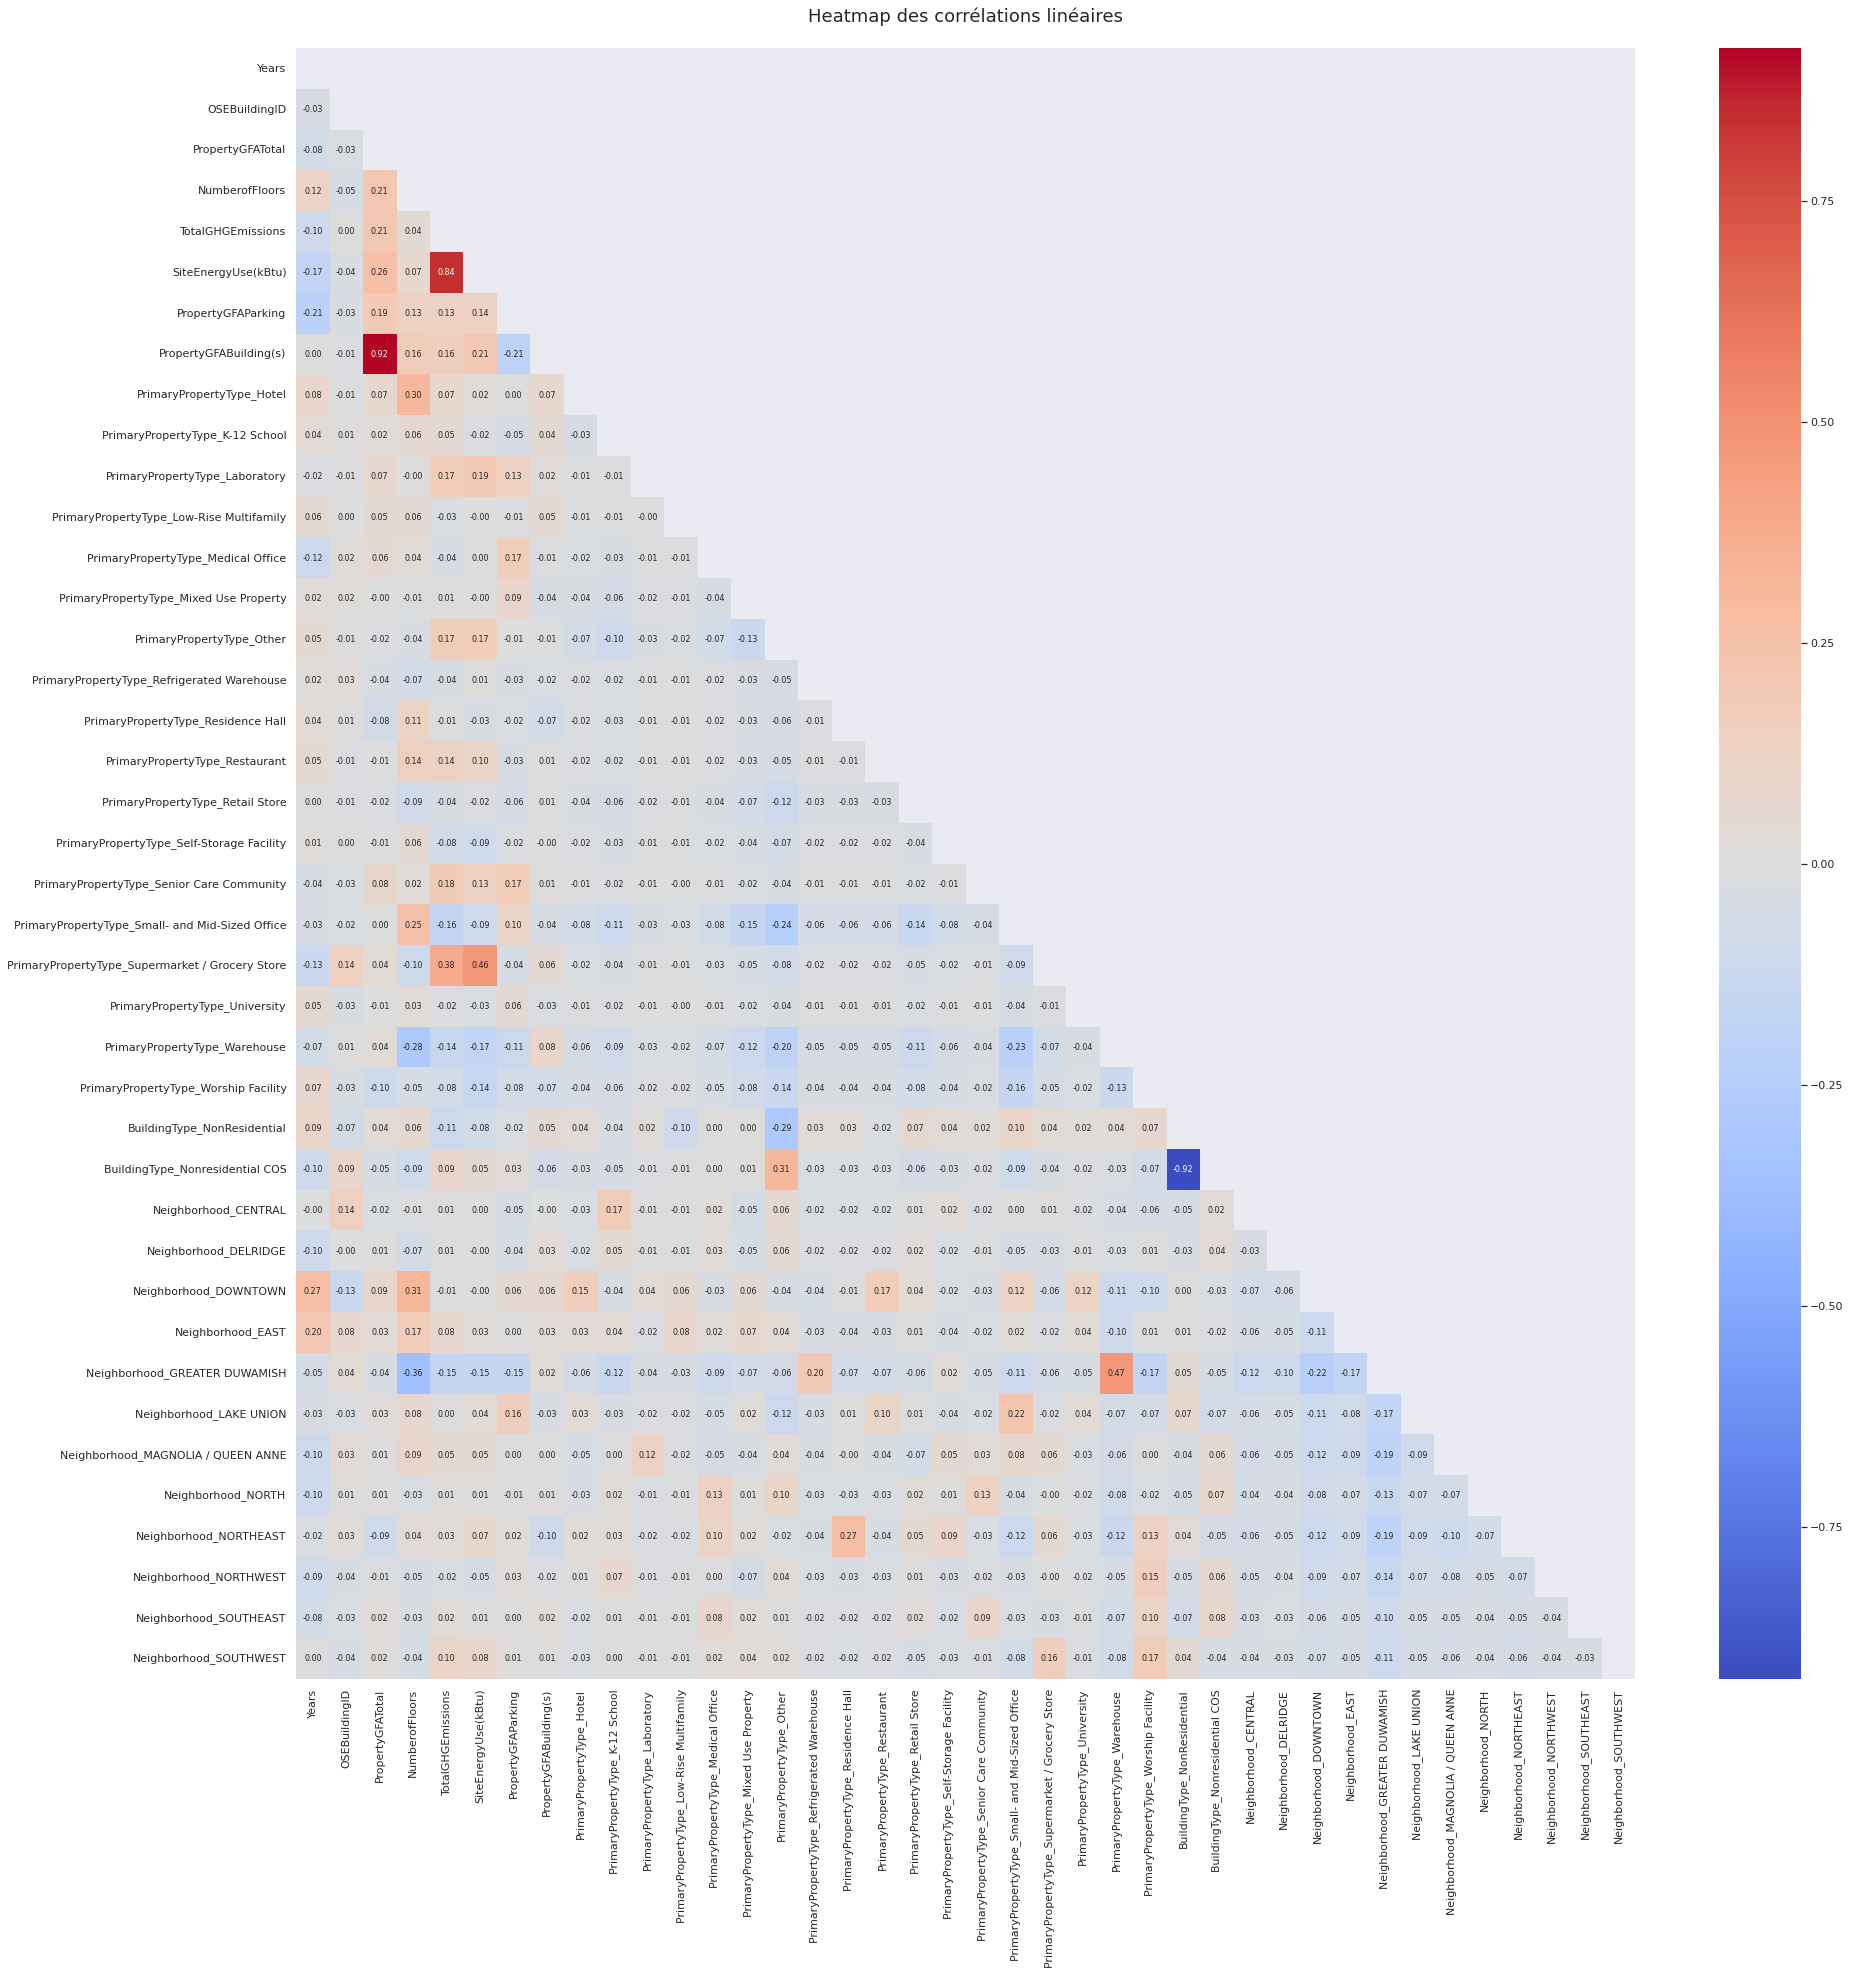

In [88]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize = 18)
plt.show()

In [89]:
df.isna().sum().sum()


0

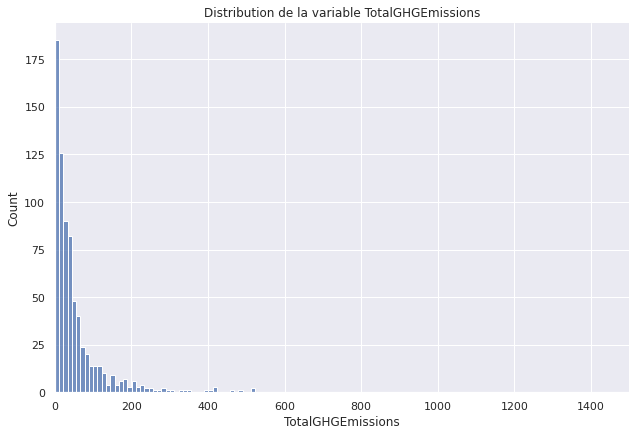

In [90]:
# Analyse de la varable TotalGHGEmissions
Var_E=sns.displot(df['TotalGHGEmissions'], palette='bright', height=6, aspect=1.5)
plt.xlim(0,1500)
Var_E.set(title="Distribution de la variable TotalGHGEmissions");

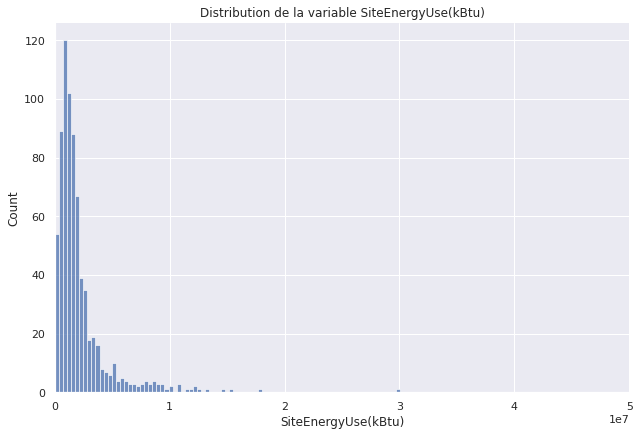

In [91]:
# Analyse de la varable SiteEnergyUse(kBtu)
Var_CO2=sns.displot(df['SiteEnergyUse(kBtu)'], palette='bright', height=6, aspect=1.5)
plt.xlim(0,0.5e8)
Var_CO2.set(title="Distribution de la variable SiteEnergyUse(kBtu)");

In [92]:
df.columns

Index(['Years', 'OSEBuildingID', 'PropertyGFATotal', 'NumberofFloors',
       'TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility', 'BuildingType_NonResidential

# 4. Exportation de dataframes

In [93]:
df_Energy = df.drop('TotalGHGEmissions', axis=1)
df_Energy

Years  OSEBuildingID  PropertyGFATotal  NumberofFloors  \
240      47            365             36000               5   
305      28            436             46710               9   
385      50            540             22780               1   
446      70          19746             23000               1   
518      91          19755             20565               3   
...     ...            ...               ...             ...   
3132     56          40034             21931               1   
3144     23          42069             26263               1   
3152    110          43948             39212               2   
3155     48          45287             21400               1   
3160     13          49687             33997               4   

      SiteEnergyUse(kBtu)  PropertyGFAParking  PropertyGFABuilding(s)  \
240          3.003849e+07                   0                   36000   
305          4.169432e+06                   0                   46710   
385          4.020513e+05                   0                   22780   
446          7.111184e+05                   0                   23000   
518          8.023125e+05                   0                   20565   
...                   ...                 ...                     ...   
3132         3.947209e+06                   0                   21931   
3144         1.634669e+06                   0                   26263   
3152         7.237040e+04                   0                   39212   
3155         5.170810e+06                   0                   21400   
3160         8.926736e+06                   0                   33997   

      PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
240                           0                                0   
305                           0                                0   
385                           0                                0   
446                           0                                0   
518                           0                                0   
...                         ...                              ...   
3132                          0                                0   
3144                          0                                0   
3152                          0                                0   
3155                          0                                0   
3160                          0                                0   

      PrimaryPropertyType_Laboratory  \
240                                0   
305                                0   
385                                0   
446                                0   
518                                0   
...                              ...   
3132                               0   
3144                               0   
3152                               0   
3155                               0   
3160                               0   

      PrimaryPropertyType_Low-Rise Multifamily  \
240                                          0   
305                                          0   
385                                          0   
446                                          0   
518                                          0   
...                                        ...   
3132                                         0   
3144                                         0   
3152                                         0   
3155                                         0   
3160                                         0   

      PrimaryPropertyType_Medical Office  \
240                                    0   
305                                    0   
385                                    0   
446                                    0   
518                                    0   
...                                  ...   
3132                                   0   
3144                                   0   
3152                                   0   
3155                 

In [94]:
df_Energy.head()

Years  OSEBuildingID  PropertyGFATotal  NumberofFloors  \
240     47            365             36000               5   
305     28            436             46710               9   
385     50            540             22780               1   
446     70          19746             23000               1   
518     91          19755             20565               3   

     SiteEnergyUse(kBtu)  PropertyGFAParking  PropertyGFABuilding(s)  \
240         3.003849e+07                   0                   36000   
305         4.169432e+06                   0                   46710   
385         4.020513e+05                   0                   22780   
446         7.111184e+05                   0                   23000   
518         8.023125e+05                   0                   20565   

     PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
240                          0                                0   
305                          0                                0   
385                          0                                0   
446                          0                                0   
518                          0                                0   

     PrimaryPropertyType_Laboratory  PrimaryPropertyType_Low-Rise Multifamily  \
240                               0                                         0   
305                               0                                         0   
385                               0                                         0   
446                               0                                         0   
518                               0                                         0   

     PrimaryPropertyType_Medical Office  \
240                                   0   
305                                   0   
385                                   0   
446                                   0   
518                                   0   

     PrimaryPropertyType_Mixed Use Property  PrimaryPropertyType_Other  \
240                                       0                          1   
305                                       0                          1   
385                                       0                          0   
446                                       0                          1   
518                                       0                          0   

     PrimaryPropertyType_Refrigerated Warehouse  \
240                                           0   
305                                           0   
385                                           0   
446                                           0   
518                                           0   

     PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
240                                   0                               0   
305                                   0                               0   
385                                   0                               0   
446                                   0                               0   
518                                   0                               0   

     PrimaryPropertyType_Retail Store  \
240                                 0   
305                                 0   
385                                 0   
446                                 0   
518                                 0   

     PrimaryPropertyType_Self-Storage Facility  \
240                                          0   
305                                          0   
385                                          0   
446                                          0   
518                                          0   

     PrimaryPropertyType_Senior Care Community  \
240                                          0   
305                                          0   
385                                          0   
446                                          0   
518                                        

In [95]:
df_Energy.isna().sum().sum()

0

In [96]:
df_CO2= df.drop('SiteEnergyUse(kBtu)', axis=1)
df_CO2

Years  OSEBuildingID  PropertyGFATotal  NumberofFloors  \
240      47            365             36000               5   
305      28            436             46710               9   
385      50            540             22780               1   
446      70          19746             23000               1   
518      91          19755             20565               3   
...     ...            ...               ...             ...   
3132     56          40034             21931               1   
3144     23          42069             26263               1   
3152    110          43948             39212               2   
3155     48          45287             21400               1   
3160     13          49687             33997               4   

      TotalGHGEmissions  PropertyGFAParking  PropertyGFABuilding(s)  \
240              209.41                   0                   36000   
305              130.69                   0                   46710   
385                2.80                   0                   22780   
446               25.74                   0                   23000   
518                5.59                   0                   20565   
...                 ...                 ...                     ...   
3132             145.11                   0                   21931   
3144              11.40                   0                   26263   
3152               0.50                   0                   39212   
3155             158.60                   0                   21400   
3160              94.63                   0                   33997   

      PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
240                           0                                0   
305                           0                                0   
385                           0                                0   
446                           0                                0   
518                           0                                0   
...                         ...                              ...   
3132                          0                                0   
3144                          0                                0   
3152                          0                                0   
3155                          0                                0   
3160                          0                                0   

      PrimaryPropertyType_Laboratory  \
240                                0   
305                                0   
385                                0   
446                                0   
518                                0   
...                              ...   
3132                               0   
3144                               0   
3152                               0   
3155                               0   
3160                               0   

      PrimaryPropertyType_Low-Rise Multifamily  \
240                                          0   
305                                          0   
385                                          0   
446                                          0   
518                                          0   
...                                        ...   
3132                                         0   
3144                                         0   
3152                                         0   
3155                                         0   
3160                                         0   

      PrimaryPropertyType_Medical Office  \
240                                    0   
305                                    0   
385                                    0   
446                                    0   
518                                    0   
...                                  ...   
3132                                   0   
3144                                   0   
3152                                   0   
3155                                   0   
3

In [97]:
df_CO2.to_parquet('df_CO2.gzip',compression='gzip')

In [98]:
df_CO2.shape

(735, 39)

In [99]:
df_Energy.to_parquet('df_Energy.gzip',compression='gzip')

In [100]:
df_Energy.shape

(735, 39)